In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import joblib
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

In [3]:
def load_and_process(file_name, positive_class):
    df = pd.read_csv(file_name)
    df['source'] = [1 if i == positive_class else 0 for i in df['subreddit']]  #Turn the positive class to 1
    df.selftext = df.selftext.fillna('to') #Filling in blanks in the subtext category with a common word 'to', 
                                           #Which will be dropped from the dataset when removing stopwords.
    df['features'] = df['title'] + df ['selftext'] #combining the title and self text into one column
    return df                             

In [5]:
df = load_and_process('Data/PFC and WSB 20200123', 'wallstreetbets')

#### Features and Train - Test Splitting our Data

In [15]:
X = df['features'] 
y = df['source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 42, stratify = y)

#Saving the results of our various models in a new Dataframe
models_df = pd.DataFrame(columns =['model', 'vectorizer', 'train_score', 'test_score', 'Precision Score', 'Recall Score'] )
#Listing the vectorizers to loop through
vectorizers = [TfidfVectorizer, CountVectorizer]

In [16]:
X.shape

(2400,)

#### K- Nearest Neighbors Model Development 

As you can see below, the K Nearest Neighbours classifier model performs quite poorly, and indicates that the model is severly overfit on the training data. 

Before we begin perfoming additional feature engineering on our data, let's test some additional model's performance. 

In [27]:
for v in vectorizers:   
    pipe = Pipeline([('vec', v()), ('knn', KNeighborsClassifier())])
    pipe_params = {'vec__max_features': [1200, 1500, 2000],
                  'vec__stop_words': [None, 'english'],
                  'vec__ngram_range' :[(1,1), (1, 2)],
                 'knn__n_neighbors': range(1, 3, 1)
                  }
    knn_gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
    knn_gs.fit(X_train, y_train)
    knn_model = knn_gs.best_estimator_
    pred = knn_model.predict(X_test) 
    display(f'The best hyperparameters are: {knn_gs.best_estimator_}')
    models_df.loc[len(models_df)] = ['KNeighborsClassifier', v, knn_model.score(X_train, y_train), knn_model.score(X_test, y_test), 
                                     precision_score(y_test, pred.round()), recall_score(y_test, pred.round())]
models_df

"The best hyperparameters are: Pipeline(steps=[('vec', TfidfVectorizer(max_features=1200)),\n                ('knn', KNeighborsClassifier(n_neighbors=1))])"

"The best hyperparameters are: Pipeline(steps=[('vec', CountVectorizer(max_features=1200)),\n                ('knn', KNeighborsClassifier(n_neighbors=2))])"

,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.999444,0.548333,0.525573,0.993333
3,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.982778,0.766667,0.702020,0.926667


If this was the only model available to perform this test, I would recommend playing with the maximum number of features and additional KNN hyper parameters. There are limits, in this case, with how many hyperparameters we can test at one time. 

## Logistic Regression Models 

In [7]:
for v in vectorizers:
    pipe = Pipeline([('vec', v()), ('lr', LogisticRegression())])
    pipe_params = {'vec__max_features': [2500, 3000, 3500],
               'vec__ngram_range' :[(1,1), (1, 2)],
               'vec__stop_words': [None, 'english'],
               'lr__penalty': ['l2', 'l1'],
               'lr__C': [0.55, 0.6, 0.63, 0.65],
               'lr__solver': ['liblinear']
                 }
    gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
    gs.fit(X_train, y_train)
    model = gs.best_estimator_
    pred = model.predict(X_test) 
    models_df.loc[len(models_df)] =  ['Logistic Regression', v , model.score(X_train, y_train), model.score(X_test, y_test), precision_score(y_test, pred.round()), 
                                      recall_score(y_test, pred.round()) ]
    print(f'The best hyperparameters are: {gs.best_estimator_}')
models_df    

The best hyperparameters are: Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=3500, stop_words='english')),
                ('lr', LogisticRegression(C=0.65, solver='liblinear'))])
The best hyperparameters are: Pipeline(steps=[('vec',
                 CountVectorizer(max_features=2500, stop_words='english')),
                ('lr', LogisticRegression(C=0.55, solver='liblinear'))])


,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,Logistic Regression,<class 'sklearn.feature_extraction.text.TfidfV...,0.978889,0.941667,0.952218,0.930000
3,Logistic Regression,<class 'sklearn.feature_extraction.text.CountV...,0.982222,0.936667,0.904321,0.976667


## Random Forest 

For the Random Forest model, I once again looped through both vecotizers to see which worked best, and saved each model to re-open later. You can see the code used to Gridsearch for the best parameters and train the model below. 

```python
    for v in vectorizers:
        count = 1
        pipe = Pipeline([('vec', v()), ('rf', RandomForestClassifier())])
        pipe_params = {'vec__max_features': [2000, 2500, 3000, 3500, 4000],
                       'vec__lowercase' : [True, False],
                       'vec__stop_words': [None, 'english'],
                       'vec__ngram_range' :[(1,1), (1, 2)],
                    'rf__n_estimators' : [100, 200],
                    'rf__max_depth' : [None, 3, 5, 10],
                    'rf__min_samples_split': [2, 3, 4] }
        gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
        gs.fit(X_train, y_train)
        model = gs.best_estimator_
          filename = f'rf_model{count}.sav'
        count = count + 2
        joblib.dump(model, filename)
        pred = model.predict(X_test)
        models_df.loc[len(models_df)] =  ['Random Forest', v , model.score(X_train,                    y_train), model.score(X_test, y_test),precision_score(y_test, pred.round()),               recall_score(y_test, pred.round()) ]
        print(f'The best hyperparameters are: {gs.best_estimator_}')
    models_df

The best hyperparameters are: Pipeline(steps=[('vec', TfidfVectorizer(max_features=2500, stop_words='english')),('rf', RandomForestClassifier(min_samples_split=4))])

    The best hyperparameters are: Pipeline(steps=[('vec', CountVectorizer(max_features=2500, ngram_range=(1, 2),
                                 stop_words='english')),
                ('rf', RandomForestClassifier(min_samples_split=3, n_estimators=200))])
CPU times: user 1h 6min 22s, sys: 14.5 s, total: 1h 6min 36s
Wall time: 1h 30min 12s
```

In [ ]:
#Loading the first random forest model, which used the Count vectorizer.
loaded_model = joblib.load('rf_model2.sav')
result = loaded_model.score(X_test, y_test)
print(result)
models_df.loc[len(models_df)] =  ['Random Forest', "<class 'sklearn.feature_extraction.text.TfidfVectorizer'>" , model.score(X_train, y_train), 
                                  model.score(X_test, y_test), precision_score(y_test, pred.round()), 
                                      recall_score(y_test, pred.round()) ]

#Loading the second random forest model which used the Tfidf vectorizer.
loaded_model = joblib.load('rf_model3.sav')
result = loaded_model.score(X_test, y_test)
print(result)
models_df.loc[len(models_df)] =  ['Random Forest', "<class 'sklearn.feature_extraction.text.CountVectorizer'>" , model.score(X_train, y_train), 
                                  model.score(X_test, y_test), precision_score(y_test, pred.round()), 
                                      recall_score(y_test, pred.round()) ]


In [19]:
models_df

,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,Logistic Regression,<class 'sklearn.feature_extraction.text.TfidfV...,0.978889,0.941667,0.952218,0.930000
3,Logistic Regression,<class 'sklearn.feature_extraction.text.CountV...,0.982222,0.936667,0.904321,0.976667
4,Random Forest,Tfidf Vectorizer,0.982222,0.936667,0.904321,0.976667
5,Random Forest,CountVectorizer,0.982222,0.936667,0.904321,0.976667


#### Support Vector Machine Classifier Model Development

In [12]:
for v in vectorizers:
    pipe = Pipeline([('vec', v()), ('svc', SVC())])
    pipe_params = {'vec__max_features': [2500, 3000, 3500],
               'vec__ngram_range' :[(1,1), (1, 2), (1,3)],
              'svc__C': [1, 2],
               'svc__kernel': ['rbf', 'linear']
             }
    gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
    gs.fit(X_train, y_train)
    model = gs.best_estimator_
    pred = model.predict(X_test) 
    models_df.loc[len(models_df)] =  ['SVC', v , model.score(X_train, y_train), model.score(X_test, y_test), precision_score(y_test, pred.round()), 
                                      recall_score(y_test, pred.round()) ]
    print(f'The best hyperparameters are: {gs.best_estimator_}')
models_df    

The best hyperparameters are: Pipeline(steps=[('vec', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('svc', SVC(C=1, kernel='linear'))])
The best hyperparameters are: Pipeline(steps=[('vec', CountVectorizer(max_features=2500)),
                ('svc', SVC(C=1, kernel='linear'))])


,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,Logistic Regression,<class 'sklearn.feature_extraction.text.TfidfV...,0.978889,0.941667,0.952218,0.930000
3,Logistic Regression,<class 'sklearn.feature_extraction.text.CountV...,0.982222,0.936667,0.904321,0.976667
4,Random Forest,<class 'sklearn.feature_extraction.text.TfidfV...,0.999444,0.920000,0.906452,0.936667
5,Random Forest,<class 'sklearn.feature_extraction.text.CountV...,0.999444,0.915000,0.897764,0.936667
6,SVC,<class 'sklearn.feature_extraction.text.TfidfV...,0.989444,0.948333,0.940984,0.956667
7,SVC,<class 'sklearn.feature_extraction.text.CountV...,0.997778,0.923333,0.889571,0.966667


## Naive Bayes Model Development

### Gaussian Naive Bayes Model

Gaussian Models require a dense matrix, which means this loop cannot be performed with other Naive Bayes Models. 

In [13]:
for v in vectorizers:
    pipe = Pipeline([('vec', v()), ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),('gaus', GaussianNB())])
    pipe_params = {'vec__max_features': [1800, 2000, 2500],
                   'vec__lowercase' : [True, False],
                  'vec__stop_words': [None, 'english'],
                   'vec__ngram_range' :[(1,1), (1, 2), (1,3)],
                  }
    gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
    gs.fit(X_train, y_train)
    model = gs.best_estimator_
    pred = model.predict(X_test)
    models_df.loc[len(models_df)] =  ['GaussianNB', v , model.score(X_train, y_train), model.score(X_test, y_test), 
                                      precision_score(y_test, pred.round()), recall_score(y_test, pred.round()) ]
    print(f'The best hyperparameters are: {gs.best_estimator_}')
models_df

The best hyperparameters are: Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('ft',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7f9fc8093dc0>)),
                ('gaus', GaussianNB())])
The best hyperparameters are: Pipeline(steps=[('vec', CountVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('ft',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7f9ff566b550>)),
                ('gaus', GaussianNB())])


,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,Logistic Regression,<class 'sklearn.feature_extraction.text.TfidfV...,0.978889,0.941667,0.952218,0.930000
3,Logistic Regression,<class 'sklearn.feature_extraction.text.CountV...,0.982222,0.936667,0.904321,0.976667
4,Random Forest,<class 'sklearn.feature_extraction.text.TfidfV...,0.999444,0.920000,0.906452,0.936667
5,Random Forest,<class 'sklearn.feature_extraction.text.CountV...,0.999444,0.915000,0.897764,0.936667
6,SVC,<class 'sklearn.feature_extraction.text.TfidfV...,0.989444,0.948333,0.940984,0.956667
7,SVC,<class 'sklearn.feature_extraction.text.CountV...,0.997778,0.923333,0.889571,0.966667
8,GaussianNB,<class 'sklearn.feature_extraction.text.TfidfV...,0.987222,0.936667,0.971223,0.900000
9,GaussianNB,<class 'sklearn.feature_extraction.text.CountV...,0.969444,0.940000,0.931373,0.950000


### Multinomial and Bernoulli Naive Bayes 

In [15]:
models = [ MultinomialNB, BernoulliNB]
X = df[['features']]        #Naive Bayes Multinomial and Bernoulli models require X to be a Dataframe
y = df['source']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

for m in models:
    for v in vectorizers:
        pipe = Pipeline([('vec', v()), ('nb', m())])
        pipe_params = {'vec__max_features': [1500, 1800, 2000, 2500],
                       'vec__lowercase' : [True, False],
              'vec__stop_words': [None, 'english'],
               'vec__ngram_range' :[(1,1), (1, 2), (1,3)]}
        gs = GridSearchCV(pipe, param_grid= pipe_params, cv = 5)
        gs.fit(X_train['features'], y_train)
        model = gs.best_estimator_
        pred = model.predict(X_test['features'])
        models_df.loc[len(models_df)] =  [m, v , model.score(X_train['features'], y_train), model.score(X_test['features'], y_test),
                                          precision_score(y_test, pred.round()), recall_score(y_test, pred.round()) ]
    print(f'The best hyperparameters are: {gs.best_estimator_}')

models_df

The best hyperparameters are: Pipeline(steps=[('vec', CountVectorizer(max_features=1800)),
                ('nb', MultinomialNB())])
The best hyperparameters are: Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1500, ngram_range=(1, 2),
                                 stop_words='english')),
                ('nb', BernoulliNB())])


,model,vectorizer,train_score,test_score,Precision Score,Recall Score
0,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.TfidfV...,0.997778,-0.806667,0.525573,0.993333
1,KNeighborsRegressor,<class 'sklearn.feature_extraction.text.CountV...,0.762778,0.031667,0.702020,0.926667
2,Logistic Regression,<class 'sklearn.feature_extraction.text.TfidfV...,0.978889,0.941667,0.952218,0.930000
3,Logistic Regression,<class 'sklearn.feature_extraction.text.CountV...,0.982222,0.936667,0.904321,0.976667
4,Random Forest,<class 'sklearn.feature_extraction.text.TfidfV...,0.999444,0.920000,0.906452,0.936667
5,Random Forest,<class 'sklearn.feature_extraction.text.CountV...,0.999444,0.915000,0.897764,0.936667
6,SVC,<class 'sklearn.feature_extraction.text.TfidfV...,0.989444,0.948333,0.940984,0.956667
7,SVC,<class 'sklearn.feature_extraction.text.CountV...,0.997778,0.923333,0.889571,0.966667
8,GaussianNB,<class 'sklearn.feature_extraction.text.TfidfV...,0.987222,0.936667,0.971223,0.900000
9,GaussianNB,<class 'sklearn.feature_extraction.text.CountV...,0.969444,0.940000,0.931373,0.950000


## Model Selection

We have tried 7 different models against the training and the testing data. We will analyse the results, and determine which model we will select to perform additional analysis. 

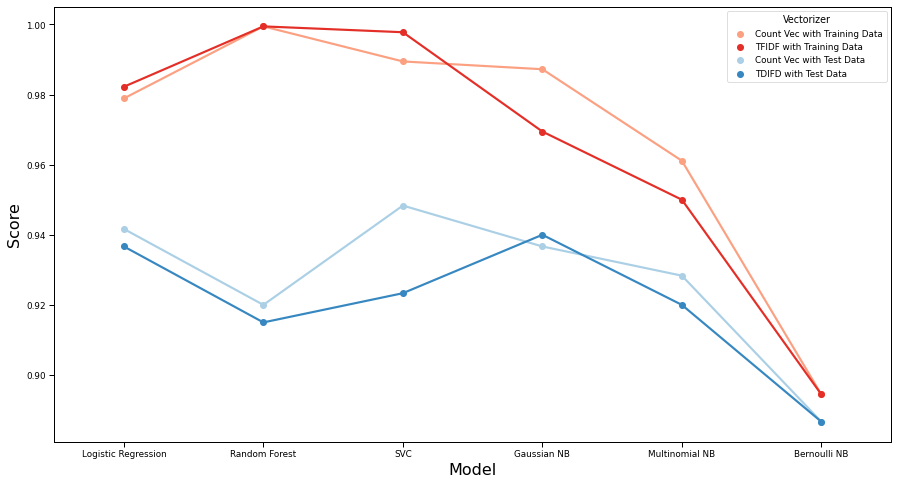

In [16]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":20,"axes.labelsize":16})   
plt.figure(figsize = (15, 8))

ax = sns.pointplot(x = "model", y = "train_score", kind = 'point', hue = 'vectorizer',
              data = models_df.drop(models_df.index[:2]), errwidth = 0, palette = 'Reds')
ax = sns.pointplot(x = "model", y = "test_score", kind = 'point',hue = 'vectorizer',
              data = models_df.drop(models_df.index[:2]), errwidth = 0, palette = 'Blues')


legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Count Vec with Training Data', 'TFIDF with Training Data',
                        'Count Vec with Test Data', 'TDIFD with Test Data'], title = 'Vectorizer',)
ax.set_xticklabels(['Logistic Regression', 'Random Forest', 'SVM', 'Gaussian NB', 
                   'Multinomial NB', 'Bernoulli NB'])
ax.set(xlabel = 'Model', ylabel = 'Score')
plt.savefig('Images and Supporting Documents/model accuracy.png');
#Dropping KNN model from the chart as the results were not useable.

We can see that a number of models performed quite well, however all were over fit. 

For exploration purposes, we will use Logistic Regression to look at what features help our model classify between subreddits. 

### Final Model Development 
From the GridSearch performed earlier, we can see that the best hyperparameters for a Logistic Regression model are:
 - TfidfVectorizer, with max features set to 2500
 - LogisticRegression, with a C value of 0.65
 
 We will re-train and save our model for further analysis and interpretation of performance and feature importance.

In [91]:
#Re-establishing our X and target variables, as well as the train-test split. 

X = df['features']
y = df['source']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

#Re-instantiating our vectorizer and model. 
tvec= TfidfVectorizer(max_features = 2500)
lr= LogisticRegression(C=0.65, solver = 'liblinear')

X_train = tvec.fit_transform(X_train)
X_test = tvec.transform(X_test)
lr.fit(X_train, y_train)
print(f'The score on the training data: {lr.score(X_train, y_train)}')
print(f'The score on the testing data: {lr.score(X_test, y_test)}')

filename = f'Saved Models/logistic regression model.sav'
joblib.dump(lr, filename)


The score on the training data: 0.9622222222222222
The score on the testing data: 0.9483333333333334


['Saved Models/logistic regression model.sav']

#### Receiver Operating Area Under the Curve

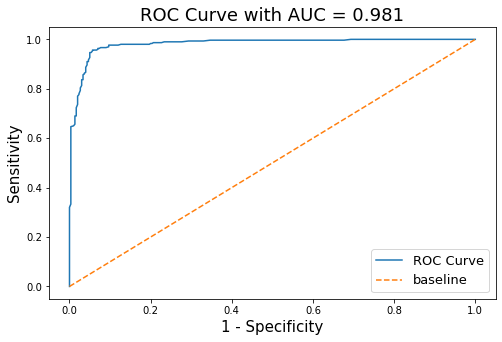

In [92]:
pred_proba = [i[1] for i in lr.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,                #Creating a Dataframe to store our positive class 
                        'pred_probs':pred_proba})             #predictions to graph the ROC

plt.figure(figsize = (8,5))
thresholds = np.linspace(0, 1, 200)

# Function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculating the sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_lr = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_lr = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Ploting ROC curve.
plt.plot(fpr_values_lr, # False Positive Rate on X-axis
         tpr_values_lr, # True Positive Rate on Y-axis
         label='ROC Curve')

# Ploting the baseline
plt.plot(np.linspace(0, 1, 200),np.linspace(0, 1, 200),label='baseline',linestyle='--')

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=18)
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('1 - Specificity', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('Images and Supporting Documents/ROC curve');

In [13]:
X_train_df = pd.DataFrame(X_train.toarray(), columns = tvec.get_feature_names())
r = permutation_importance(lr, X_train.toarray(), y_train, n_repeats=10)

In [14]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train_df.columns[i]:<8}"
     f"{r.importances_mean[i]:.5f}"
    f" +/- {r.importances_std[i]:.5f}")

gme     0.02100 +/- 0.00295
removed 0.01761 +/- 0.00473
bb      0.00267 +/- 0.00131
wsb     0.00228 +/- 0.00088
short   0.00222 +/- 0.00075
tfsa    0.00211 +/- 0.00105
you     0.00206 +/- 0.00093
stock   0.00167 +/- 0.00035
going   0.00150 +/- 0.00025
squeeze 0.00133 +/- 0.00057
td      0.00133 +/- 0.00044
10      0.00128 +/- 0.00036
shorts  0.00128 +/- 0.00036
big     0.00122 +/- 0.00042
little  0.00111 +/- 0.00025
code    0.00111 +/- 0.00000
price   0.00106 +/- 0.00017
play    0.00106 +/- 0.00017
go      0.00106 +/- 0.00017
condo   0.00089 +/- 0.00037
sure    0.00089 +/- 0.00037
retard  0.00078 +/- 0.00027
home    0.00078 +/- 0.00027
ei      0.00078 +/- 0.00027
employer0.00078 +/- 0.00027
gonna   0.00078 +/- 0.00037
use     0.00078 +/- 0.00037
wealthsimple0.00072 +/- 0.00025
commission0.00067 +/- 0.00033
com     0.00067 +/- 0.00022
plan    0.00067 +/- 0.00022
period  0.00067 +/- 0.00022
vgro    0.00067 +/- 0.00022
late    0.00067 +/- 0.00033
wondering0.00067 +/- 0.00022
degenerates0.

### Testing Accuracy on Additional Datasets

To gain some insight into how well our model can predict a subreddit origin in the future, we will test data scraped from Reddit on January 27th and February 22nd.


The predictions value counts are: 
1    1257
0    1143
Name: lr predictions, dtype: int64,

The accuracy is: 0.9379166666666666,
The precision is: 0.9578361177406524,
The recall score is: 0.9261538461538461


The predictions value counts are: 
0    1229
1    1171
Name: lr predictions, dtype: int64,

The accuracy is: 0.9054166666666666,
The precision is: 0.9154568744662681,
The recall score is: 0.8933333333333333



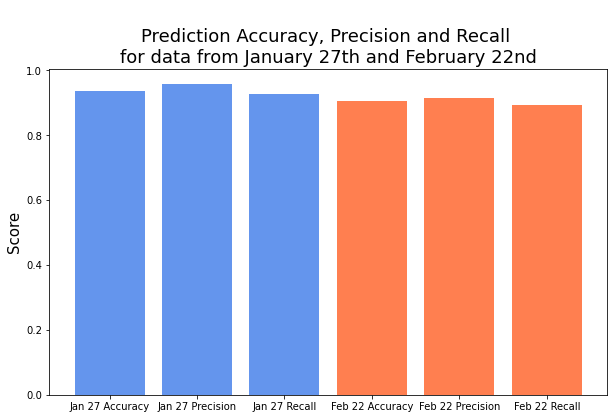

In [108]:
jan27 = load_and_process('Data/PFC and WSB 20200127', 'wallstreetbets')

X_jan = jan27['features']
y_jan = jan27['source']
X_jan = tvec.transform(X_jan)
jan27['lr predictions'] = lr.predict(X_jan)
preds_jan = lr.predict(X_jan)
print(f"""
The predictions value counts are: 
{jan27['lr predictions'].value_counts()},

The accuracy is: {accuracy_score(y_jan, preds_jan)},
The precision is: {precision_score(y_jan, preds_jan)},
The recall score is: {recall_score(y_jan, preds_jan)}
""")


feb22 = load_and_process('Data/PFC and WSB 20200222', 'wallstreetbets')
X_feb = feb22['features']
y_feb = feb22['source']
X_feb = tvec.transform(X_feb)
feb22['lr predictions'] = lr.predict(X_feb)
preds_feb = lr.predict(X_feb)
print(f"""
The predictions value counts are: 
{feb22['lr predictions'].value_counts()},

The accuracy is: {accuracy_score(y_feb, preds_feb)},
The precision is: {precision_score(y_feb, preds_feb)},
The recall score is: {recall_score(y_feb, preds_feb)}
""")

plt.figure(figsize = (10, 6))


plt.bar('Jan 27 Accuracy', accuracy_score(y_jan, preds_jan), color = 'cornflowerblue')
plt.bar('Jan 27 Precision', precision_score(y_jan, preds_jan), color = 'cornflowerblue')
plt.bar('Jan 27 Recall', recall_score(y_jan, preds_jan), color = 'cornflowerblue')
plt.bar('Feb 22 Accuracy', accuracy_score(y_feb, preds_feb), color = 'coral')
plt.bar('Feb 22 Precision', precision_score(y_feb, preds_feb), color = 'coral')
plt.bar('Feb 22 Recall', recall_score(y_feb, preds_feb), color = 'coral')

plt.title("""
Prediction Accuracy, Precision and Recall 
for data from January 27th and February 22nd""", fontsize=18)
plt.ylabel('Score', fontsize=15)
plt.savefig('Images and Supporting Documents/Jan and Feb predictions.png');


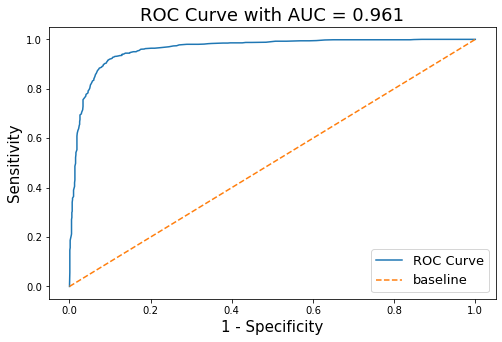

In [101]:
pred_proba = [i[1] for i in lr.predict_proba(X_feb)]
pred_df = pd.DataFrame({'true_values': y, 'pred_probs':pred_proba})             

plt.figure(figsize = (8,5))
    
# Calculating the sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_lr = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_lr = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Ploting ROC curve.
plt.plot(fpr_values_lr, tpr_values_lr, label='ROC Curve')

# Ploting the baseline
plt.plot(np.linspace(0, 1, 200),np.linspace(0, 1, 200),label='baseline',linestyle='--')

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=18)
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('1 - Specificity', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('Images and Supporting Documents/ROC curve feb 22')

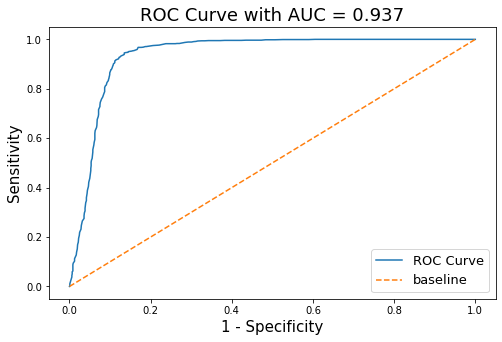

In [105]:
pred_proba = [i[1] for i in lr.predict_proba(X_jan)]
pred_df = pd.DataFrame({'true_values': y, 'pred_probs':pred_proba})             

plt.figure(figsize = (8,5))
thresholds = np.linspace(0, 1, 200)

# Calculating the sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_lr = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_lr = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Ploting ROC curve.
plt.plot(fpr_values_lr, tpr_values_lr, label='ROC Curve')

# Ploting the baseline
plt.plot(np.linspace(0, 1, 200),np.linspace(0, 1, 200),label='baseline',linestyle='--')

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=18)
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('1 - Specificity', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('Images and Supporting Documents/ROC curve jan')